In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob2
import math
import numpy as np
import os
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks_cwt

from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [10]:

def camera_Calibraton(directory, filename, nx, ny, img_size):
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    objpoints = [] 
    imgpoints = []

    # Image List
    images = glob2.glob('./'+directory+'/'+filename+'*'+'.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    if (len(objpoints) == 0 or len(imgpoints) == 0):
        raise Error("Calibration Failed")
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        
    return mtx, dist

def undistort(image, mtx, dist):
    image = cv2.undistort(image, mtx, dist, None, mtx)
    return image

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    assert(orient == 'x' or orient == 'y'), "Orientation must be x or y"
    
    if orient == 'x':
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    else:
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
 
    return grad_binary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobelxy = np.power((np.power(sobelx,2)+np.power(sobely,2)),0.5)
    
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

def sobel_combined(image):
    # Apply combined sobel filter
    img_g_mag = mag_thresh(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined

def threshold_Channel(channel,thresh):
    retval, binary = cv2.threshold(channel.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    return binary

def channel_Isolate(image,channel):
    ## Takes in only RBG images
    if (channel == 'R'):
        return image[:,:,0]
    
    elif (channel == 'G'):
        return image[:,:,1]
    
    elif (channel == 'B'):
        return image[:,:,2]
    
    elif (channel == 'H'):
        HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        return HSV[:,:,0]
    
    elif (channel == 'S'):
        HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        return HSV[:,:,1]
        
    elif (channel == 'V'):
        HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        return HSV[:,:,2]
        
    elif (channel == 'L'):
        HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        return HLS[:,:,1]
    
        
def transform_perspective(undist):
    img_size = undist.shape
    #src_2 =  np.float32([[250,700],[1200,700],[550,450],[750,450]])
    #dst_2 = np.float32([[250,700],[1200,700],[300,50],[1000,50]])
    src = np.array([[585. /1280.*img_size[1], 455./720.*img_size[0]],
                        [705. /1280.*img_size[1], 455./720.*img_size[0]],
                        [1130./1280.*img_size[1], 720./720.*img_size[0]],
                        [190. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
    dst = np.array([[300. /1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 720./720.*img_size[0]],
                        [300. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
    #src =  np.float32([[203,720],[1127,720],[585,460],[695,460]])
    #dst = np.float32([[320,720],[960,720],[320,0],[960,0]])
    #src = np.array([[585, 460], [203, 720], [1127, 720], [695, 460]]).astype(np.float32)
    #dst = np.array([[320, 0], [320, 720], [960, 720], [960, 0]]).astype(np.float32)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, (undist.shape[1], undist.shape[0]),flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped,M,Minv

def color_mask(trans_persp):
    red_threshed = threshold_Channel(channel_Isolate(trans_persp,'R'),(220,255))
    V_threshed = threshold_Channel(channel_Isolate(trans_persp,'V'),(220,255))        
    HSV = cv2.cvtColor(trans_persp, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(HSV, (0, 100, 100), (50, 255, 255))
    sensitivity_1 = 68
    white = cv2.inRange(HSV, (20,0,180), (255,80,255))
    sensitivity_2 = 60
    HSL = cv2.cvtColor(trans_persp, cv2.COLOR_RGB2HLS)
    #white_2 = cv2.inRange(HSL, (0,255-sensitivity_2,0), (255,255,sensitivity_2))
    #white_3 = cv2.inRange(trans_persp, (200,200,200), (255,255,255))
    #bit_layer = red_threshed | V_threshed | yellow | white | white_2 | white_3
    bit_layer = red_threshed | V_threshed | yellow | white
    return bit_layer


def apply_sobel_filter(trans_persp):
    image_HLS = cv2.cvtColor(trans_persp,cv2.COLOR_RGB2HLS)
    img_gs = image_HLS[:,:,1]
    sobel_c = sobel_combined(img_gs)
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
    wraped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    img_gs = image_HLS[:,:,2]
    sobel_c = sobel_combined(img_gs)
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))
    wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    image_combi = cv2.bitwise_or(wraped2,wraped3)
    return image_combi

def combine_color_sobel(bit_layer,image_combi):
    image = np.zeros_like(image_combi)
    image[(bit_layer>=.5)|(bit_layer>=.5)]=1
    return image

def get_mask_poly(img,poly_fit,window_sz):
    # This function returns masks for points used in computing polynomial fit. 
    mask_poly = np.zeros_like(img)
    img_size = np.shape(img)

    poly_pts = []
    pt_y_all = []

    for i in range(8):
        img_y1 = img_size[0]-img_size[0]*i/8
        img_y2 = img_size[0]-img_size[0]*(i+1)/8

        pt_y = (img_y1+img_y2)/2
        pt_y_all.append(pt_y)
        poly_pt = np.round(poly_fit[0]*pt_y**2 + poly_fit[1]*pt_y + poly_fit[2])
    
        poly_pts.append(poly_pt)
    
        mask_poly[img_y2:img_y1,poly_pt-window_sz:poly_pt+window_sz] = 1.     

    return mask_poly, np.array(poly_pts),np.array(pt_y_all)

def draw_lines(img,pts,color):
    # draw lines
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)

def get_quadratic(y,pol_a):
    # Returns value of a quadratic polynomial 
    return pol_a[0]*y**2+pol_a[1]*y+pol_a[2]
        
        
def get_curvature(poly,y_pt):
    # Returns curvature of a quadratic
    yscale = 30 / 720 # Real world metres per y pixel
    xscale = 3.7 / 700 # Real world metres per x pixel
 
    # Convert polynomial to set of points for refitting
    ploty = np.linspace(0, y_pt-1, y_pt)
    fitx = poly[0] * ploty ** 2 + poly[1] * ploty + poly[2]
 
    #Fit new polynomial
    fit_cr = np.polyfit(ploty * yscale, fitx * xscale, 2)
    # Calculate curve radius
    curverad = ((1 + (2 * fit_cr[0] * np.max(ploty) * yscale + fit_cr[1]) ** 2)  ** 1.5) / np.absolute(2 * fit_cr[0])
    return curverad 

def find_offset(l_poly, r_poly):
    lane_width = 3.7 # metres
    h = 720 # height of image (index of image bottom)
    w = 1280 # width of image
    # Find the bottom pixel of the lane lines
    l_px = l_poly[0] * h ** 2 + l_poly[1] * h + l_poly[2]
    r_px = r_poly[0] * h ** 2 + r_poly[1] * h + r_poly[2]
    # Find the number of pixels per real metre
    scale = lane_width / np.abs(l_px - r_px)
    # Find the midpoint
    midpoint = np.mean([l_px, r_px])
    # Find the offset from the centre of the frame, and then multiply by scale
    offset = (w/2 - midpoint) * scale
    return offset 

In [11]:
def get_mask_first_time(img,window_size):
    img_size = np.shape(img)
    mov_filtsize = img_size[1]/20.
    histogram = np.sum(img[img_size[0]/2:,:],axis=0)
    indexes = find_peaks_cwt(histogram,[100], max_distances=[800])

    val_ind = np.array([histogram[indexes[i]] for i in range(len(indexes)) ])
    ind_sorted = np.argsort(-val_ind)

    ind_peakR = indexes[ind_sorted[0]]
    ind_peakL = indexes[ind_sorted[1]]
    
    if ind_peakR<ind_peakL:
        ind_temp = ind_peakR
        ind_peakR = ind_peakL
        ind_peakL = ind_temp

    n_vals = 8
    ind_min_L = ind_peakL-window_size
    ind_max_L = ind_peakL+window_size

    ind_min_R = ind_peakR-window_size
    ind_max_R = ind_peakR+window_size

    mask_L_poly = np.zeros_like(img)
    mask_R_poly = np.zeros_like(img)

    ind_peakR_prev = ind_peakR
    ind_peakL_prev = ind_peakL
    
    diff_R = 0
    diff_L = 0
    for i in range(8):
        

        
        img_y1 = img_size[0]-img_size[0]*i/8
        img_y2 = img_size[0]-img_size[0]*(i+1)/8
    
        mean_lane_y = np.mean(img[img_y2:img_y1,:],axis=0)
        mean_lane_y = moving_average(mean_lane_y,mov_filtsize)
        indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
        
        if len(indexes)>1.5:
            val_ind = np.array([histogram[indexes[i]] for i in range(len(indexes)) ])
            ind_sorted = np.argsort(-val_ind)

            ind_peakR = indexes[ind_sorted[0]]
            ind_peakL = indexes[ind_sorted[1]]
            if ind_peakR<ind_peakL:
                ind_temp = ind_peakR
                ind_peakR = ind_peakL
                ind_peakL = ind_temp
            
        else:
            if len(indexes)==1:
                if np.abs(indexes[0]-ind_peakR_prev)<np.abs(indexes[0]-ind_peakL_prev):
                    ind_peakR = indexes[0]
                    ind_peakL = ind_peakL_prev+diff_R
                else:
                    ind_peakL = indexes[0]
                    ind_peakR = ind_peakR_prev+diff_R
            else:
                ind_peakL = ind_peakL_prev+diff_R
                ind_peakR = ind_peakR_prev+diff_R
            
                
        if np.abs(ind_peakL-ind_peakL_prev)>=100:
            ind_peakL = ind_peakL_prev
        if np.abs(ind_peakR-ind_peakR_prev)>=100:
            ind_peakR = ind_peakR_prev
    
            
        mask_L_poly[img_y2:img_y1,ind_peakL-window_size:ind_peakL+window_size] = 1.     
        mask_R_poly[img_y2:img_y1,ind_peakR-window_size:ind_peakR+window_size] = 1.
        
        if i == 0:
            window_size= window_size/1
   
        if i>0:
            diff_R = ind_peakL-ind_peakL_prev
            diff_L = ind_peakR-ind_peakR_prev

    
        ind_peakL_prev = ind_peakL
        ind_peakR_prev = ind_peakR
        
        
        
    return mask_L_poly,mask_R_poly

In [12]:
def pipeline(image, mtx, dist):
    global left_fit_prev   
    global right_fit_prev
    global flag
    
    image_undist = undistort(image, mtx, dist)
    trans_persp,M,Minv=transform_perspective(image_undist)
    bit_layer=color_mask(trans_persp)
    image_combi=apply_sobel_filter(trans_persp)
    image_combi_1=combine_color_sobel(bit_layer,image_combi)
    mask_L_poly,mask_R_poly = get_mask_first_time(image_combi_1,50)
    img_size = np.shape(image_combi_1)
    mask_L = mask_L_poly
    img_L = np.copy(image_combi_1)
    img_L = cv2.bitwise_and(img_L,img_L,mask=mask_L_poly)

    mask_R = mask_R_poly
    img_R = np.copy(image_combi_1)
    img_R = cv2.bitwise_and(img_R,img_R,mask=mask_R_poly)
    
    vals = np.argwhere(img_L>.8)
    #print(len(vals))
    if len(vals)<5: ## If less than 5 points 
        left_fit = left_fit_prev
    else:
        all_x = vals.T[0]
        all_y =vals.T[1]
        left_fit = np.polyfit(all_x, all_y, 2)
        
            
    # Apply mask to sobel images and compute polynomial fit for right. 

    img_R = np.copy(image_combi_1)
    img_R = cv2.bitwise_and(image_combi_1,image_combi_1,mask = mask_R_poly)
    vals = np.argwhere(img_R>.8)
    #print(len(vals))    
    if len(vals)<5:
        right_fit = right_fit_prev
    else:
        all_x = vals.T[0]
        all_y =vals.T[1]
        right_fit = np.polyfit(all_x, all_y, 2)
        
    
    ## assign initial mask, and save coefficient values for next frame
            
    if flag == 0:
        flag = 1
        right_fit_prev = right_fit
        left_fit_prev  = left_fit
    
    ## Check error between current coefficient and on from previous frame
    err_p_R = np.sum((right_fit[0]-right_fit_prev[0])**2) 
    err_p_R = np.sqrt(err_p_R)
    #print(err_p_R)
    if err_p_R>0.00107:
        right_fit = right_fit_prev
    #else:
        #right_fit =right_fit_prev#.90*right_fit+.10*right_fit_prev
        
    ## Check error between current coefficient and on from previous frame
    #err_p_L = np.sum((left_fit[0]-left_fit_prev[0])**2) 
    #err_p_L = np.sqrt(err_p_L)
    #print(err_p_L)
    #if err_p_L>0.0004:
    #    left_fit =  left_fit_prev
    #else:
    #    left_fit =  left_fit_prev#.10* left_fit+.90* left_fit_prev
    
    
    left_y = np.arange(11)*img_size[0]/10
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]

    right_y = np.arange(11)*img_size[0]/10
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]

    window_sz = 60
    mask_L_poly = np.zeros_like(image_combi_1)
    mask_R_poly = np.zeros_like(image_combi_1)

    left_pts = []
    right_pts = []

    pt_y_all = []

    for i in range(8):  #find all left and right points
        img_y1 = img_size[0]-img_size[0]*i/8
        img_y2 = img_size[0]-img_size[0]*(i+1)/8
    

        pt_y = (img_y1+img_y2)/2
        pt_y_all.append(pt_y)
        left_pt = np.round(left_fit[0]*pt_y**2 + left_fit[1]*pt_y + left_fit[2])
        right_pt = np.round(right_fit[0]*pt_y**2 + right_fit[1]*pt_y + right_fit[2])
    
        right_pts.append(right_fit[0]*pt_y**2 + right_fit[1]*pt_y + right_fit[2])
        left_pts.append(left_fit[0]*pt_y**2 + left_fit[1]*pt_y + left_fit[2])
    
        mask_L_poly[img_y2:img_y1,left_pt-window_sz:left_pt+window_sz] = 1.     
        mask_R_poly[img_y2:img_y1,right_pt-window_sz:right_pt+window_sz] = 1.  
        
    warp_zero = np.zeros_like(image_combi_1).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,255))
        
    col_L = (255,255,255)
    col_R = (255,255,255)

    draw_lines(color_warp,np.int_(pts_left),col_L)
    draw_lines(color_warp,np.int_(pts_right),col_R)

    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    result = cv2.addWeighted(image_undist, 1, newwarp, 0.5, 0)
    left_radius = get_curvature(left_fit,img_size[0])
    right_radius = get_curvature(right_fit,img_size[0])
    str_curv = 'Curvature: Right = ' + str(np.round(right_radius,2)) + ', Left = ' + str(np.round(left_radius,2))
    offset=find_offset(left_fit,right_fit)
    str_offset = 'Lane deviation: ' + str(round(offset, 4)) + ' m.'
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(result, str_curv, (30, 60), font, 1, (255,255,0), 2)
    cv2.putText(result, str_offset, (30, 90), font, 1, (255,255,0), 2)
    return result

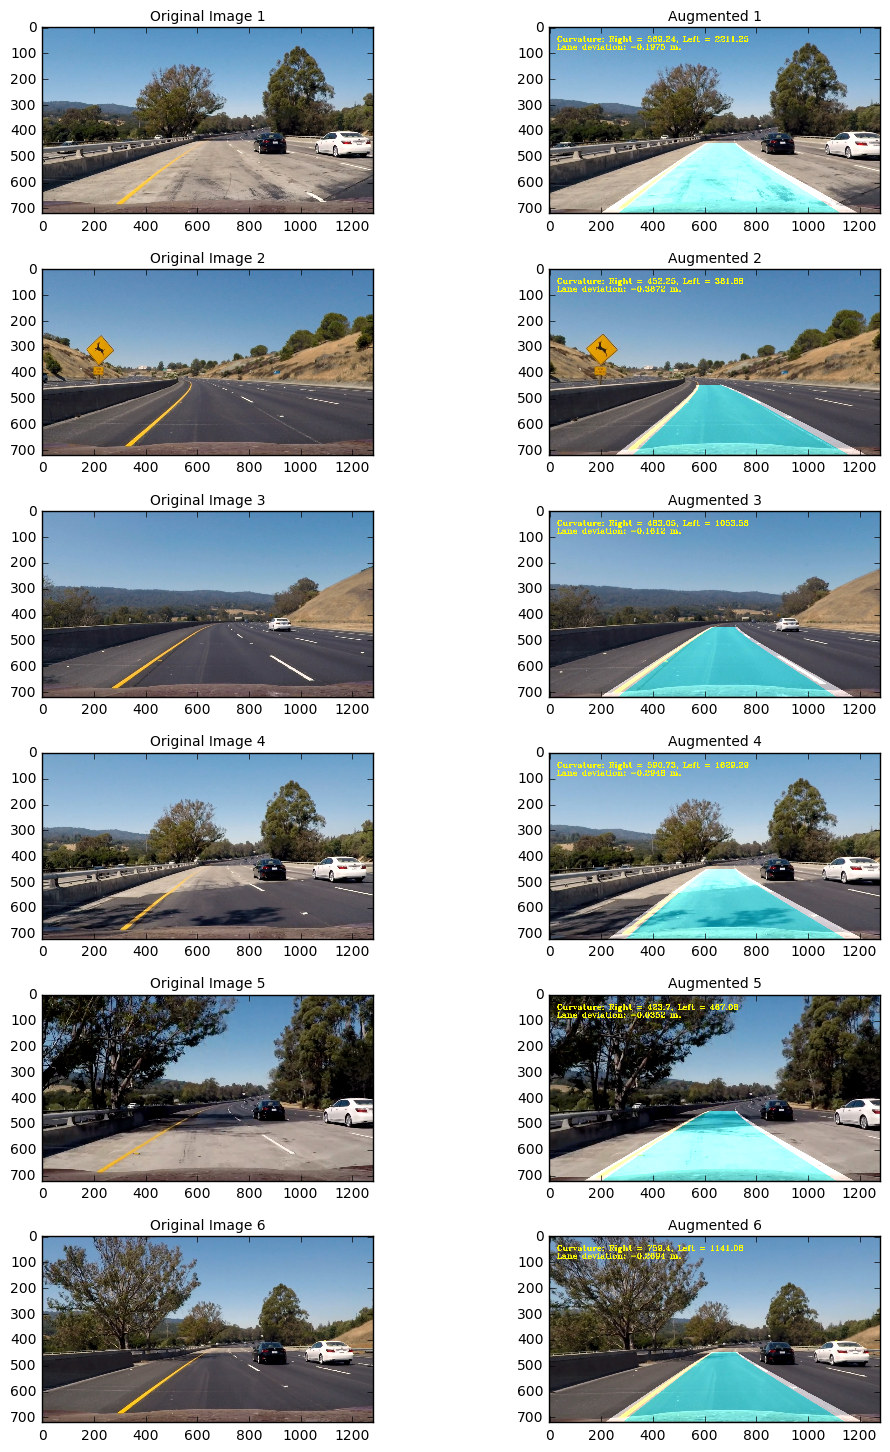

In [13]:
mtx, dist = camera_Calibraton('camera_cal', 'calibration', 9, 6, (720, 1280))
flag = 0 #flags main use is for videos
dirname = 'output_images'
image = mpimg.imread("./test_images/straight_lines2.jpg")
image_1 = mpimg.imread("./test_images/test1.jpg")
image_2 = mpimg.imread("./test_images/test2.jpg")
image_3 = mpimg.imread("./test_images/test3.jpg")
image_4 = mpimg.imread("./test_images/test4.jpg")
image_5 = mpimg.imread("./test_images/test5.jpg")
image_6 = mpimg.imread("./test_images/test6.jpg")

result_1=pipeline(image_1,mtx, dist)
flag = 0
result_2=pipeline(image_2,mtx, dist)
flag = 0
result_3=pipeline(image_3,mtx, dist)
result_4=pipeline(image_4,mtx, dist)
flag = 0
result_5=pipeline(image_5,mtx, dist)
flag = 0
result_6=pipeline(image_6,mtx, dist)

#os.chdir(dirname)
cv2.imwrite("result_1.jpg", cv2.cvtColor(result_1, cv2.COLOR_BGR2RGB))
cv2.imwrite("result_2.jpg", cv2.cvtColor(result_2, cv2.COLOR_BGR2RGB))
cv2.imwrite("result_3.jpg", cv2.cvtColor(result_3, cv2.COLOR_BGR2RGB))
cv2.imwrite("result_4.jpg", cv2.cvtColor(result_4, cv2.COLOR_BGR2RGB))
cv2.imwrite("result_5.jpg", cv2.cvtColor(result_5, cv2.COLOR_BGR2RGB))
cv2.imwrite("result_6.jpg", cv2.cvtColor(result_6, cv2.COLOR_BGR2RGB))

f, ((ax1, ax2), (ax3, ax4),(ax5, ax6), (ax7, ax8),(ax9, ax10), (ax11, ax12)) = plt.subplots(6, 2, figsize=(12, 18))
ax1.imshow(image_1)
ax1.set_title('Original Image 1', fontsize=10)
ax2.imshow(result_1)
ax2.set_title('Augmented 1', fontsize=10)
ax3.imshow(image_2)
ax3.set_title('Original Image 2', fontsize=10)
ax4.imshow(result_2)
ax4.set_title('Augmented 2', fontsize=10)
ax5.imshow(image_3)
ax5.set_title('Original Image 3', fontsize=10)
ax6.imshow(result_3)
ax6.set_title('Augmented 3', fontsize=10)
ax7.imshow(image_4)
ax7.set_title('Original Image 4', fontsize=10)
ax8.imshow(result_4)
ax8.set_title('Augmented 4', fontsize=10)
ax9.imshow(image_5)
ax9.set_title('Original Image 5', fontsize=10)
ax10.imshow(result_5)
ax10.set_title('Augmented 5', fontsize=10)
ax11.imshow(image_6)
ax11.set_title('Original Image 6', fontsize=10)
ax12.imshow(result_6)
ax12.set_title('Augmented 6', fontsize=10)

plt.subplots_adjust(hspace=0.3)

In [6]:
flag=0
project_output = 'project_video_output_1.mp4'
clip1 = VideoFileClip("project_video.mp4");
white_clip = clip1.fl_image(lambda img: pipeline(img, mtx, dist)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output_1.mp4
[MoviePy] Writing video project_video_output_1.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [17:12<00:00,  1.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_1.mp4 

Wall time: 17min 26s


In [7]:
#challenge_video_output = 'challenge_video_output.mp4'
#clip1 = VideoFileClip("challenge_video.mp4");
#white_clip = clip1.fl_image(lambda img: pipeline(img, mtx, dist)) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(challenge_video_output, audio=False)

In [8]:
#harder_challenge_video_output = 'harder_challenge_video_output.mp4'
#clip1 = VideoFileClip("harder_challenge_video.mp4");
#white_clip = clip1.fl_image(lambda img: pipeline(img, mtx, dist)) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(harder_challenge_video_output, audio=False)